# GSD 192 Interface Bluesky

The GSD192 interface for bluesky should behave like any other ophyd EPICS detector.

### Bluesky Setup

In [1]:
from bluesky import RunEngine

RE = RunEngine({})

Print data collection status updates

In [2]:
from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

0

Enable data storage so we can access scans later (this is just a `temp` database. Use an actual one for real data)

In [3]:
from databroker import catalog
db = Broker.named('temp')

RE.subscribe(cat)

/local/home/dpuser/.local/lib/python3.7/site-packages/pims/image_reader.py:26: RuntimeWarning: PIMS image_reader.py could not find scikit-image. Falling back to matplotlib's imread(), which uses floats instead of integers. This may break your scripts. 
(To ignore this warning, include the line "warnings.simplefilter("ignore", RuntimeWarning)" in your script.)
  warnings.warn(RuntimeWarning(ski_preferred))


1

Add a progress bar

In [4]:
from progressbar_fixed import ProgressBarManager
RE.waiting_hook = ProgressBarManager(delay_draw=0.2)

Add metadata

In [5]:
RE.md["beamline_id"] = "Unknown"
RE.md["experiment"] = "Test run"

### GSD192 Setup

The GSD192 class is implemented according to https://nsls-ii.github.io/bluesky/hardware.html#ReadableDevice.

It will automatically apply the default settings to the detector when instantiated. This can be disabled by passing `keep_configuration=True`.

The data collection time can be set using `.configure(time=<time in seconds>)`

To adjust detector gain, threshold, or shaping time, use `.configure(gain=..., threshold=..., shaping=...)`. **Passing any of these 3 arguments will override all configuration done outside this notebook!**

In [8]:
from gsd192_interface import GSD192

det = GSD192(
    ip_addr="tcp://10.0.143.160", # IP Address of the detector
    name="GSD192", # Name used by bluesky for the detector
    keep_configuration=False # Keep previous detector settings
)

# Set data collection time to 30 seconds
det.configure(time=3)

# Configure detector
det.configure(gain=2, threshold=215, shaping=2)

help(det.configure)

print(det)

Help on method configure in module gsd192_interface:

configure(gain: int = None, shaping: int = None, threshold: int = None, time: int = None) -> Tuple[Dict[str, Any], Dict[str, Any]] method of gsd192_interface.GSD192 instance
    Configure the detector.
    
    :param gain: Detector gain. (0:200, 1:100, 2:50, 3:25 keV) (Default: 0)
    :param shaping: Shaping time. (0:0.25, 1:1, 2:0.5, 3:2 usec) (Default: 2)
    :param threshold: Threshold. 0-1023 (Default: 215)
    :param time: Data collection time in seconds. (Default: 60)

GSD192 Detector
shaping:   2 (0.5 usec)
gain:      2 (50 keV)
threshold: 215
time:      3


The `det` object can now be used like any other `ophyd` EPICS detector. 

A scan result has 3 data fields. `mca` contains data like an `.mca` file (counts for every channel of every strip), `strip_counts` is an array containing counts for every strip, and `total_counts` is the total number of events detected.

### Example data collection

Collecting data once (duration is still set to 3 seconds)

In [13]:
from bluesky.plans import count

RE(count([det]))



Transient Scan ID: 2     Time: 2020-07-13 16:24:38
Persistent Unique Scan ID: '61028abc-f105-4b69-9478-02364cbee1c8'


'GSD192: 100%|█████████████████████████████| 2.999/2.999 [00:03<00:00,  1.00s/s]'

New stream: 'primary'
+-----------+------------+--------------+
|   seq_num |       time | total_counts |
+-----------+------------+--------------+
|         1 | 16:24:41.1 |    15005.000 |
+-----------+------------+--------------+
generator count ['61028abc'] (scan num: 2)





('61028abc-f105-4b69-9478-02364cbee1c8',)

Using a simulated motor, collect data at 5 points between `-1` and `1` for 2 seconds each.



Transient Scan ID: 3     Time: 2020-07-13 16:47:31
Persistent Unique Scan ID: '1e8afae0-e673-45a4-8c6e-be23706f4b9a'


'GSD192: 100%|█████████████████████████████████| 2.0/2.0 [00:02<00:00,  1.00s/s]'

New stream: 'primary'
+-----------+------------+------------+--------------+
|   seq_num |       time |      motor | total_counts |
+-----------+------------+------------+--------------+
|         1 | 16:47:34.2 |     -1.000 |    22636.000 |


'motor [In progress. No progress bar available.]                                '

'GSD192: 100%|█████████████████████████████| 2.001/2.001 [00:02<00:00,  1.00s/s]'

|         2 | 16:47:36.9 |     -0.500 |    15168.000 |


'GSD192: 100%|█████████████████████████████| 2.001/2.001 [00:02<00:00,  1.00s/s]'

|         3 | 16:47:39.7 |      0.000 |    15006.000 |


'GSD192: 100%|█████████████████████████████████| 2.0/2.0 [00:02<00:00,  1.00s/s]'

|         4 | 16:47:42.6 |      0.500 |    14830.000 |


'GSD192: 100%|█████████████████████████████████| 2.0/2.0 [00:02<00:00,  1.00s/s]'

|         5 | 16:47:45.5 |      1.000 |    15104.000 |
+-----------+------------+------------+--------------+
generator scan ['1e8afae0'] (scan num: 3)





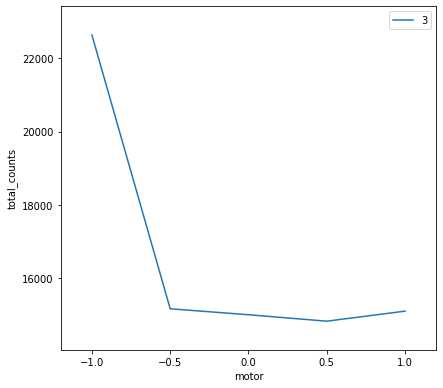

In [14]:
from ophyd.sim import motor
from bluesky.plans import scan

det.configure(time=2)

uid, = RE(scan([det], motor, -1, 1, 5))

The full data for every run can be accessed using the `db` variable.

In [8]:
db[uid].table()

,time,motor,motor_setpoint,mca,strip_counts,total_counts
seq_num,,,,,,
1,2020-07-13 20:58:28.317293406,-1.0,-1.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",225742.0
2,2020-07-13 20:58:30.441912651,-0.5,-0.5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14822.0
3,2020-07-13 20:58:32.626485348,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15094.0
4,2020-07-13 20:58:34.836899281,0.5,0.5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15094.0
5,2020-07-13 20:58:37.038161516,1.0,1.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14877.0


In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt_name = "Motor position {} data".format(list(db[uid].data("motor"))[0])
plt.figure(plt_name)
plt.title(plt_name)
plt.imshow(list(db[uid].data("mca"))[0], aspect=10)

<IPython.core.display.Javascript object>

In [10]:
import numpy as np

with np.errstate(divide='ignore', invalid='ignore'):
    plt_name = "Single scan data"
    plt.figure(plt_name)
    plt.title(plt_name)
    # This was the second to last run, so the data is at -2
    plt.imshow([np.log(x) for x in list(db[-2].data("mca"))[0]], aspect=10)

<IPython.core.display.Javascript object>

In [11]:
from collections import OrderedDict
print(OrderedDict(db[-2].documents())['descriptor'])
run_duration = OrderedDict(db[-2].documents())['descriptor']['configuration']['GSD192']['data']['time']
print(run_duration)


Event Descriptor
configuration   :
      shaping         : 2                                       
      gain            : 0                                       
      threshold       : 215                                     
      time            : 30                                      
      shaping         : 1594673875.5743082                      
      gain            : 1594673875.5743065                      
      threshold       : 1594673875.574309                       
      time            : 1594673875.5742073                      
        source          : No source                               
        dtype           : number                                  
        shape           : []                                      
        source          : No source                               
        dtype           : number                                  
        shape           : []                                      
        source          : No source       

In [12]:
det.read()

OrderedDict([('mca',
              {'value': array([[0., 0., 0., ..., 0., 0., 0.],
                      [0., 0., 0., ..., 0., 0., 0.],
                      [0., 0., 0., ..., 0., 0., 0.],
                      ...,
                      [0., 0., 0., ..., 0., 0., 0.],
                      [0., 0., 0., ..., 0., 0., 0.],
                      [0., 0., 0., ..., 0., 0., 0.]]),
               'timestamp': 1594673704.1842525}),
             ('strip_counts',
              {'value': array([ 73.,  71.,  79.,  61.,  63.,  73.,  82.,  72.,  72.,  54.,  77.,
                       67.,  78.,  76.,  57.,  71.,  72.,  81.,  66.,  68.,  84.,  64.,
                       58.,  60.,  68.,  64.,  81.,  94.,  68.,  80.,  82.,  87.,  68.,
                       61.,  77.,  80.,  84.,  75.,  83.,  60.,  70.,  77.,  66.,  81.,
                       71.,  79.,  71.,  68.,  78.,  66.,  75.,  67.,  72.,  75.,  79.,
                       62.,  72.,  74.,  76.,  69.,  78.,  81.,  85.,  81.,  85.,  70.,
      